# Introduction

## Librairies

In [1]:
import os, gc, time, joblib
from contextlib import contextmanager
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Config

In [6]:
STORAGE_PATH = "../data/"
FILE_NAME = "data.f"

## Metrics

In [4]:
n = 100
y_true = np.random.randint(2, size=n)
y_pred = np.random.randint(2, size=n)

In [4]:
cm = confusion_matrix(y_true, y_pred)
tn, fn, fp, tp = cm[0, 0], cm[1, 0], cm[0, 1], cm[1, 1]

In [5]:
print("""
Number of true negative:\t%s (%s)
Number of false negative:\t%s (%s)
Number of false positive:\t%s (%s)
Number of true positive:\t%s (%s)
""" % (tn, tn/n, fn, fn/n, fp, fp/n, tp, tp/n))


Number of true negative:	23 (0.23)
Number of false negative:	33 (0.33)
Number of false positive:	24 (0.24)
Number of true positive:	20 (0.2)



### Recall

Le recall mesure la proportion des client prédit non solvable parmis tous les non solvables.

$\text{Recall}=\frac{TP}{TP + FN}$

In [6]:
recall_score(y_true, y_pred)

0.37735849056603776

### Precision

La precision mesure le nombre de client véritablement non solvable parmis tous ceux qui sont prédits non solvables.

$\text{Precision}=\frac{TP}{TP + FP}$

In [7]:
precision_score(y_true, y_pred)

0.45454545454545453

### F1-score

Le F1 score combine la precision et le recall en faisant leur moyenne harmonique.

$F1 = 2 \times \frac{precision \times recall}{precision + recall}$

In [8]:
f1_score(y_true, y_pred)

0.41237113402061865

### F-beta score

Nous cherchons ici à trouver le maximum de client non solvables, quite pour ca à se tromper sur la prédiction des solvables. Pour cela nous devons maximiser le recall.

Le F-beta score est une variante du F1 score qui introduit une variable $\beta$ qui fait varier le poids du recall par rapport à la precision. Lorsque $\beta$ tend vers 0, le poids du recall devient négligeable et de même pour la precision quand il tend vers l'infini.

$F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}$

In [9]:
fbeta_score(y_true, y_pred, beta=1) == f1_score(y_true, y_pred)

True

In [10]:
fbeta_score(y_true, y_pred, beta=0) == precision_score(y_true, y_pred)

False

In [11]:
round(fbeta_score(y_true, y_pred, beta=1000), 4) == round(recall_score(y_true, y_pred), 4)

True

### Penalisation des faux negatifs

Les faux négatifs sont les clients non solvables predits solvables. Nous cherchons ici à minimiser ces faux négatifs dans le f1-score.

In [12]:
def f1_score_with_penalty(y_true, y_pred, penalty=float):
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fn, fp, tp = cm[0, 0], cm[1, 0], cm[0, 1], cm[1, 1]
    fn = fn * (1 + penalty)
    f1 = tp / (tp + 0.5 * (fp + fn))
    
    return f1

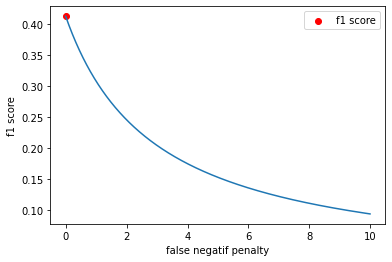

In [13]:
max_p = 10
score = [f1_score_with_penalty(y_true, y_pred, penalty=p) for p in np.arange(0, max_p, 0.01)]
plt.plot(np.arange(0, max_p, 0.01), score)
plt.scatter(0, f1_score(y_true, y_pred), c='r', label='f1 score')

plt.xlabel('false negatif penalty')
plt.ylabel('f1 score')
plt.legend()
plt.show()

Pour combiner la minimisation du recall et des faux positifs, nous ajoutons cette pénalité au F-beta score.

In [14]:
def custom_fbeta_score(y_true, y_pred, beta, penalty=float):
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fn, fp, tp = cm[0, 0], cm[1, 0], cm[0, 1], cm[1, 1]
    fn = fn * (1 + penalty)
    fbeta = ((1 + beta**2) * tp) / ((1 + beta**2) * tp + beta**2 * fn + fp)
    
    return fbeta

Nous allons maintenant évaluer sur ces différentes métriques plusieurs modèle de classification sur nos données afin de voir comment celles-ci varies et quel modèle retenir pour la suite.

In [15]:
def evaluate_model(y_true, y_pred, beta, penalty, verbose=False):
    
    r = recall_score(y_test, y_pred)
    p = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fb = fbeta_score(y_test, y_pred, beta=beta)
    cfb = custom_fbeta_score(y_test, y_pred, beta=beta, penalty=penalty)
    
    if verbose:
        print(f"""

{classification_report(y_true, y_pred)}

SUMMARY
-------
* recall:\t{round(r, 3)}
* precision:\t{round(p, 3)}
* f1:\t\t{round(f1, 3)}
* fbeta:\t{round(fb, 3)}
* custom fbeta:\t{round(cfb, 3)}
""")
        
    return r, p, f1, fb, cfb

# Data

In [5]:
data = pd.read_feather(os.path.join(STORAGE_PATH, FILE_NAME))
data.set_index('SK_ID_CURR', inplace=True)
data.replace(np.inf, np.NaN, inplace=True)

In [6]:
X = data.drop(columns='TARGET')
y = data.TARGET

feature_dict = {f"feature_{index}": column  for index, column in enumerate(X.columns)}
X.columns = feature_dict.keys()

In [10]:
joblib.dump(feature_dict, '../api/inputs/model_feature_dict.p')

['../api/inputs/model_feature_dict.p']

## EDA

### Target

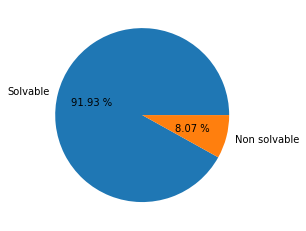

In [18]:
plt.pie(y.value_counts(), labels= ['Solvable', 'Non solvable'], autopct= lambda x: f"{str(round(x, 2))} %")
plt.show()

### Missing values

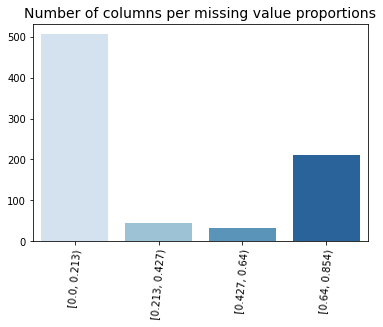

In [19]:
na_count = X.isna().sum() / len(X)
_ = pd.cut(na_count, 4, right=False).value_counts()

sns.barplot(x = _.index, y = _.values, palette='Blues')
plt.title('Number of columns per missing value proportions', size=14)
plt.xticks(rotation=85)
plt.show()

In [20]:
# remove columns with more than > 20% of missing values
X = X[X.columns[X.isna().sum() / len(data) <= 0.2]]
X.shape

(307507, 506)

# Model selection

In [21]:
from lightgbm import LGBMClassifier
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#from xgboost import XGBClassifier
#from sklearn.pipeline import Pipeline
#from sklearn.model_selection import ParameterGrid
#from tqdm import tqdm

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [23]:
#del data
#gc.collect()
#del X
#gc.collect()
#del y
#gc.collect()

In [24]:
#param_grid = dict(
#    imputer__add_indicator = [True, False],
#    estimator = [
#        LGBMClassifier(random_state=0),
#        RandomForestClassifier(random_state=0),
#        AdaBoostClassifier(random_state=0),
#        XGBClassifier(random_state=0)
#    ]
#)

#recall_scores = list()
#precision_scores = list()
#f1_scores = list()
#fbeta_scores = list()
#custom_fbeta_scores = list()

#for params in tqdm(ParameterGrid(param_grid)):
    
#    pipe = Pipeline([
#        ('imputer', KNNImputer()),
#        ('estimator', 'passthrough')])
#    pipe.set_params(**params)
    
#    pipe.fit(X_train, y_train)
#    y_pred = pipe.predict(X_test)
    
#    recall_scores.append(recall_score(y_test, y_pred))
#    precision_scores.append(precision_score(y_test, y_pred))
#    f1_scores.append(f1_score(y_test, y_pred))
#    fbeta_scores.append(fbeta_score(y_test, y_pred, beta=3))
#    custom_fbeta_scores.append(custom_fbeta_score(y_test, y_pred, beta=3, penalty=0.1))

# Feature selection

In [25]:
%%time
params = {
    'boosting_type': 'goss',
    'verbosity': 1,
    'random_state':0
}

estimator = LGBMClassifier(**params)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.912615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45617
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 497
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
CPU times: user 1min 12s, sys: 5.95 s, total: 1min 18s
Wall time: 35.7 s


In [26]:
scores = evaluate_model(y_test, y_pred, beta=3, penalty=0.2, verbose=True)



              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.54      0.03      0.06      4965

    accuracy                           0.92     61502
   macro avg       0.73      0.52      0.51     61502
weighted avg       0.89      0.92      0.89     61502


SUMMARY
-------
* recall:	0.034
* precision:	0.543
* f1:		0.065
* fbeta:	0.038
* custom fbeta:	0.032



In [27]:
feature_importance_df = pd.DataFrame({'value': estimator.feature_importances_, 'feature_code': X_train.columns})
feature_importance_df["feature"] = feature_importance_df.feature_code.apply(lambda x: feature_dict[x])

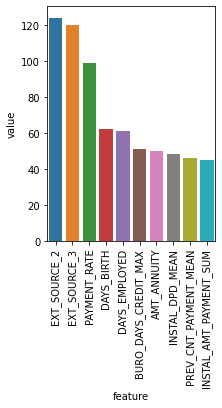

In [28]:
plt.figure(figsize=(4, 4))
sns.barplot(x = 'feature', y = 'value', data = feature_importance_df.sort_values('value', ascending=False).iloc[0:10])
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [29]:
feature_importance_df.describe()

,value
count,506.000000
mean,5.928854
std,12.480277
min,0.000000
25%,0.000000
50%,1.000000
75%,7.000000
max,124.000000


In [30]:
features = feature_importance_df.loc[feature_importance_df.value > 0, "feature_code"].values
X = X[features]
X.shape

(307507, 297)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

# Sampling

## Undersampling

In [32]:
sampler = RandomUnderSampler(sampling_strategy=0.4, random_state=0)
X_train_samp, y_train_samp = sampler.fit_resample(X_train, y_train)

X_train_samp.index = sampler.sample_indices_
y_train_samp.index = sampler.sample_indices_

y_train_samp.value_counts(normalize=True)

0    0.714286
1    0.285714
Name: TARGET, dtype: float64

In [33]:
%%time
estimator = LGBMClassifier(**params)
estimator.fit(X_train_samp, y_train_samp)
y_pred = estimator.predict(X_test)

[LightGBM] [Info] Number of positive: 19860, number of negative: 49650
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.261038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40746
[LightGBM] [Info] Number of data points in the train set: 69510, number of used features: 297
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285714 -> initscore=-0.916291
[LightGBM] [Info] Start training from score -0.916291
CPU times: user 23.4 s, sys: 1.41 s, total: 24.8 s
Wall time: 15.9 s


In [34]:
scores = evaluate_model(y_test, y_pred, beta=3, penalty=0.2, verbose=True)



              precision    recall  f1-score   support

           0       0.94      0.91      0.92     56537
           1       0.27      0.39      0.32      4965

    accuracy                           0.86     61502
   macro avg       0.60      0.65      0.62     61502
weighted avg       0.89      0.86      0.88     61502


SUMMARY
-------
* recall:	0.387
* precision:	0.266
* f1:		0.315
* fbeta:	0.37
* custom fbeta:	0.335



## SMOTE

In [35]:
from sklearn.impute import SimpleImputer

In [36]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

sampler = SMOTE(sampling_strategy=0.3, random_state=0)
X_train_samp, y_train_samp = sampler.fit_resample(X_train_imp, y_train)

y_train_samp.value_counts(normalize=True)

0    0.769232
1    0.230768
Name: TARGET, dtype: float64

In [37]:
%%time
estimator = LGBMClassifier(**params)
estimator.fit(X_train_samp, y_train_samp)
y_pred = estimator.predict(X_test)

[LightGBM] [Info] Number of positive: 67843, number of negative: 226145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.301283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73904
[LightGBM] [Info] Number of data points in the train set: 293988, number of used features: 297
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230768 -> initscore=-1.203980
[LightGBM] [Info] Start training from score -1.203980
CPU times: user 1min 10s, sys: 2.25 s, total: 1min 12s
Wall time: 24 s


In [38]:
scores = evaluate_model(y_test, y_pred, beta=3, penalty=0.2, verbose=True)



              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.52      0.03      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502


SUMMARY
-------
* recall:	0.026
* precision:	0.518
* f1:		0.049
* fbeta:	0.028
* custom fbeta:	0.024



## Automatic class weight balancing

In [39]:
params = {
    'boosting_type': 'goss',
    'verbosity': 1,
    'is_unbalance': True,
    'random_state':0
}

In [40]:
%%time
estimator = LGBMClassifier(**params)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.765978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42197
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 297
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
CPU times: user 1min 4s, sys: 4.12 s, total: 1min 8s
Wall time: 24.1 s


In [41]:
scores = evaluate_model(y_test, y_pred, beta=3, penalty=0.2, verbose=True)



              precision    recall  f1-score   support

           0       0.96      0.72      0.83     56537
           1       0.18      0.69      0.29      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.71      0.56     61502
weighted avg       0.90      0.72      0.78     61502


SUMMARY
-------
* recall:	0.694
* precision:	0.181
* f1:		0.287
* fbeta:	0.541
* custom fbeta:	0.518



## Custom class weight balancing

In [42]:
params = {
    'boosting_type': 'goss',
    'verbosity': 1,
    'scale_pos_weight': 2
}


In [43]:
%%time
estimator = LGBMClassifier(**params)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.992433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42176
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 297
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
CPU times: user 1min 2s, sys: 2.33 s, total: 1min 5s
Wall time: 21.1 s


In [44]:
scores = evaluate_model(y_test, y_pred, beta=3, penalty=0.2, verbose=True)



              precision    recall  f1-score   support

           0       0.93      0.99      0.96     56537
           1       0.44      0.13      0.20      4965

    accuracy                           0.92     61502
   macro avg       0.68      0.56      0.58     61502
weighted avg       0.89      0.92      0.89     61502


SUMMARY
-------
* recall:	0.126
* precision:	0.435
* f1:		0.196
* fbeta:	0.136
* custom fbeta:	0.116



# Hyperparameters fine tuning

In [45]:
params = {
    'boosting_type': 'goss',
    'verbosity': 1,
    'is_unbalance': True,
    'random_state':0
}

In [46]:
X_train.shape

(246005, 297)

In [47]:
%%time
estimator = LGBMClassifier(**params)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.739806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42197
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 297
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
CPU times: user 1min 3s, sys: 2.43 s, total: 1min 6s
Wall time: 21.5 s


# Save model and data

In [49]:
joblib.dump(estimator, os.path.join('../api/inputs', 'model.p'))

['../api/inputs/model.p']

In [53]:
X_sample = X.sample(10000, random_state=0)

In [54]:
X_sample.reset_index().to_feather(os.path.join('../api/inputs', 'train_sample.f'))
X.reset_index().to_feather(os.path.join(STORAGE_PATH, 'train.f'))
application = pd.read_feather(os.path.join(STORAGE_PATH, 'application.f'))
application_sample = application.loc[application.SK_ID_CURR.isin(X_sample.index)].reset_index(drop=True)
application_sample.to_feather(os.path.join('../api/inputs', 'application_sample.f'))